In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import time
# from tqdm.notebook import tqdm

module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import ResNet as net_regular

    
import Resnet_multiscale_general as net


mse_list = list()
step_size_list = list()
noise_list = list()
t_list_all = list()


In [11]:
#===========================================================================================================

# adjustables

k = 2                       # model index: should be in {0, 2, ..., 10}
dt = 0.02                     # time unit: 0.0005 for Lorenz and 0.01 for others
system = 'VanDerPol'         # system name: 'Hyperbolic', 'Cubic', 'VanDerPol', 'Hopf' or 'Lorenz'

step_size = 4
noise = 0.1                   # noise percentage: 0.00, 0.01 or 0.02

lr = 1e-3                     # learning rate
max_epoch = 50000            # the maximum training epoch 
batch_size = 320              # training batch size
arch = [2, 512, 512, 512, 2]  # architecture of the neural network

# paths
data_dir = os.path.join('../../data/', system,)
model_dir = '../../models/VanDerPol_multiscale_general'

# global const
n_forward = 6
# step_size = 2**k


        
# load data
train_data = np.load(os.path.join(data_dir, 'train_noise{}.npy'.format(noise)))
val_data = np.load(os.path.join(data_dir, 'val_noise{}.npy'.format(noise)))
test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise)))
n_train = train_data.shape[0]
n_val = val_data.shape[0]
n_test = test_data.shape[0]

print("train_data shape = ", train_data.shape)
print("val_data shape = ", val_data.shape)
print("test_data.shape = ", test_data.shape)

# n_forward = int(64/4)

# dataset = net.DataSet(train_data, val_data, test_data, dt, step_size, n_forward)

# print(dataset.train_ys.shape)

train_data shape =  (3200, 5121, 2)
val_data shape =  (320, 5121, 2)
test_data.shape =  (320, 5121, 2)


In [12]:
# load models
models = list()
#add letter models and the one without a letter. 
# model_name = 'model_D{}_noise{}.pt'.format(step_size, noise)
# models.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))

for letter in  ['a']:#'a', 'b', 'c', 'd', 'e']:
    # for noise in noise_levels:
#     try:
        model_name = 'model_D{}_noise{}_{}.pt'.format(step_size, noise, letter)
        print(model_name)
        print(os.path.join(model_dir, model_name))
        models.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
#     except:
#         print("not found")
#         break

for model in models:
    # fix model consistencies trained on gpus (optional)
    model.device = 'cpu'
    for step_size in model.step_sizes:
        model._modules[str(step_size)]._modules['activation'] = torch.nn.ReLU()
#     model._modules['large']._modules['activation'] = torch.nn.ReLU()
  

model_D4_noise0.1_a.pt
../../models/VanDerPol_multiscale_general/model_D4_noise0.1_a.pt


/home/kjohnst/.local/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/kjohnst/.local/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [13]:
# load models
models_regular = list()
model_dir_regular = '../../models/VanDerPol'
#add letter models and the one without a letter. 
# model_name = 'model_D{}_noise{}.pt'.format(step_size, noise)
# models.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))

for step_size_this in [4,8,16]:
    # for noise in noise_levels:
    try:
        model_name = 'model_D{}_noise{}.pt'.format(step_size_this, noise)
        print(model_name)
        models_regular.append(torch.load(os.path.join(model_dir_regular, model_name), map_location='cpu'))
    except:
        print("not found")
        break

for model in models_regular:
    # fix model consistencies trained on gpus (optional)
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()
  

model_D4_noise0.1.pt
model_D8_noise0.1.pt
model_D16_noise0.1.pt


/home/kjohnst/.local/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/kjohnst/.local/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [14]:
test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise)))

In [15]:
#want to find mse when just considering the smaller timescale

def predict_single_scale(model1, step_size, test_data=test_data, timesteps = 5000, size='small', to_plot=True ):

    t = 0
    print(step_size)

    points = timesteps // step_size + 1


    t_list = np.zeros(points)
    y_pred_list = np.zeros((320, points, 2))

    t+= step_size
    y_preds = model1.forward(torch.tensor(test_data[:, 0]).float(), size)
    y_pred_list[:,0] = y_preds.detach().numpy()
    t_list[0] = t
    print(y_preds.shape)

    for j in range(points-1):
        t+= step_size
        y_preds = model1.forward(y_preds, size)

        y_pred_list[:,j+1] = y_preds.detach().numpy()
        t_list[j+1] = t


    
    # need to interpolate between timesteps
    y_pred_list_new = np.zeros((320, timesteps - step_size, 2))
    t_list_new = np.arange(step_size, timesteps)
    for i in range(len(y_pred_list)):
        for j in range(2):
            f = interp1d(t_list, y_pred_list[i,:,j])
            y_pred_list_new[i,:,j] = f(t_list_new)
    
    plt_idx = 1
    
    if to_plot:
        plt.plot(t_list_new, y_pred_list_new[plt_idx,:, 1])
        plt.plot(t_list_new, y_pred_list_new[plt_idx,:, 0])

        plt.plot(t_list, test_data[plt_idx,t_list.astype(int), 1])
        plt.plot(t_list, test_data[plt_idx,t_list.astype(int), 0])
        plt.title("step_size = " + str(step_size))

        plt.show()
    
    mse = np.mean((y_pred_list_new - test_data[:,t_list_new.astype(int)])**2, axis = (0,2))
    if to_plot:
        plt.semilogy(t_list_new, mse)

        plt.show()
    
    
    return y_pred_list_new, mse, t_list_new
 




4
torch.Size([320, 2])


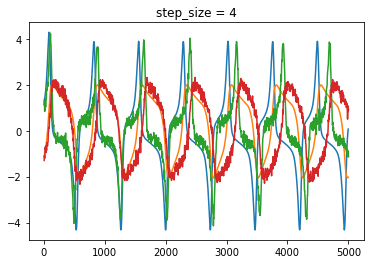

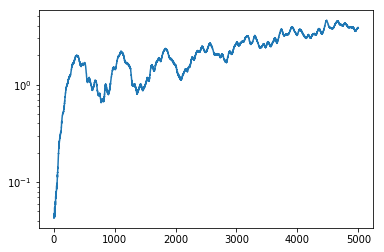

8
torch.Size([320, 2])


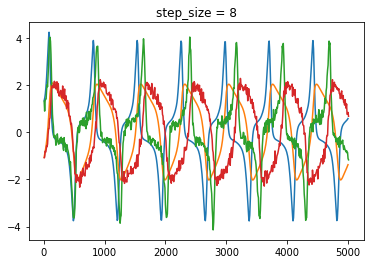

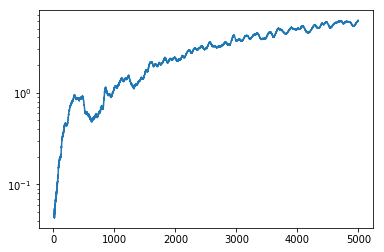

16
torch.Size([320, 2])


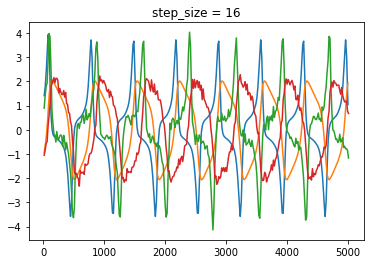

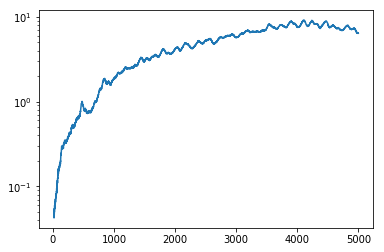

In [16]:
to_plot = True
y_pred_list_small, mse_small, t_list = predict_single_scale(models[0], 4, test_data=test_data, timesteps = 5000, 
                                                            size='4', to_plot=to_plot)
y_pred_list_mid, mse_mid, t_list_mid = predict_single_scale(models[0], 8, test_data=test_data, timesteps = 5000, 
                                                            size='8',to_plot=to_plot)
y_pred_list_large, mse_large, t_list_large = predict_single_scale(models[0], 16, test_data=test_data, timesteps = 5000, 
                                                                  size="16",to_plot=to_plot)


/home/kjohnst/multiscale_HiTS_depends/src/ResNet.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))


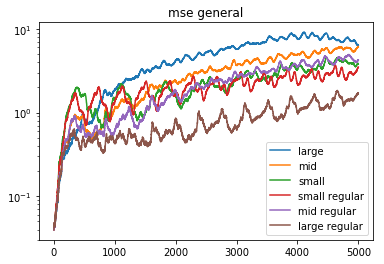

In [17]:

plt.semilogy(t_list_large, mse_large, label = "large")
plt.semilogy(t_list_mid, mse_mid, label = "mid")
plt.semilogy(t_list, mse_small, label = "small")
plt.title("mse general")

# plt.xlim([0,1000])
# plt.ylim([0.0001, 1])

n_steps=5000
y_preds = models_regular[0].uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
mse = torch.mean((y_preds - torch.tensor(test_data[:, 1:1+n_steps, :]).float())**2, axis = (0,2))
plt.plot(mse, label = "small regular")

y_preds = models_regular[1].uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
mse = torch.mean((y_preds - torch.tensor(test_data[:, 1:1+n_steps, :]).float())**2, axis = (0,2))
plt.plot(mse, label = "mid regular")

y_preds = models_regular[2].uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
mse = torch.mean((y_preds - torch.tensor(test_data[:, 1:1+n_steps, :]).float())**2, axis = (0,2))
plt.plot(mse, label = "large regular")
plt.legend()

# y_preds = net_regular.vectorized_multi_scale_forecast(torch.tensor(test_data[:, 0, :]).float().to('cpu'), n_steps=n_steps, models=models_regular)
# mse_regular = torch.mean((y_preds - torch.tensor(test_data[:, 1:1+n_steps, :]).float())**2, axis = (0,2))
# plt.semilogy(mse_regular, label = " multiscale regular")

plt.legend()

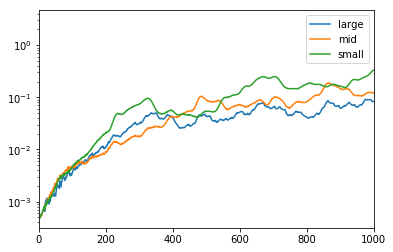

In [119]:

plt.semilogy(t_list_large, mse_large, label = "large")
plt.semilogy(t_list_mid, mse_mid, label = "mid")
plt.semilogy(t_list, mse_small, label = "small")

plt.xlim([0,1000])
# plt.ylim([0.0001, 1])

# n_steps=5000
# y_preds = models_regular[0].uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
# mse = torch.mean((y_preds - torch.tensor(test_data[:, 1:1+n_steps, :]).float())**2, axis = (0,2))
# plt.plot(mse, label = "small regular")

# y_preds = models_regular[1].uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
# mse = torch.mean((y_preds - torch.tensor(test_data[:, 1:1+n_steps, :]).float())**2, axis = (0,2))
# plt.plot(mse, label = "mid regular")

# y_preds = models_regular[2].uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
# mse = torch.mean((y_preds - torch.tensor(test_data[:, 1:1+n_steps, :]).float())**2, axis = (0,2))
# plt.plot(mse, label = "large regular")
# plt.legend()

# y_preds = net_regular.vectorized_multi_scale_forecast(torch.tensor(test_data[:, 0, :]).float().to('cpu'), n_steps=n_steps, models=models_regular)
# mse_regular = torch.mean((y_preds - torch.tensor(test_data[:, 1:1+n_steps, :]).float())**2, axis = (0,2))
# plt.semilogy(mse_regular, label = " multiscale regular")

plt.legend()

In [120]:
to_plot = False
y_pred_list_small, mse_small1, t_list = predict_single_scale(models[0], step_size, test_data=test_data, timesteps = 5000, 
                                                            size="small", to_plot=to_plot)
y_pred_list_large, mse_large1, t_list_large = predict_single_scale(models[0], step_size*4, test_data=test_data, timesteps = 5000, 
                                                                  size="large",to_plot=to_plot)
y_pred_list_mid, mse_mid1, t_list_mid = predict_single_scale(models[0], step_size*2, test_data=test_data, timesteps = 5000, 
                                                            size='mid',to_plot=to_plot)

plt.semilogy(t_list_large, mse_large, 'r', label = "large")
plt.semilogy(t_list_mid, mse_mid, 'orange', label = "mid")
plt.semilogy(t_list, mse_small, 'yellow', label = "small")
plt.legend()
plt.xlim([0,1000])
# plt.ylim([0.0001, 1])

16


KeyError: 'small'

In [ ]:
# plt.semilogy(t_list_large, mse_large, 'r', label = "large")
# plt.semilogy(t_list_mid, mse_mid, 'orange', label = "mid")
plt.semilogy(t_list, mse_small, 'yellow', label = "small")
plt.legend()
plt.xlim([0,1000])

# plt.semilogy(t_list_large, mse_large1, 'r--', label = "large")
# plt.semilogy(t_list_mid, mse_mid1, '--', color='orange', label = "mid")
plt.semilogy(t_list, mse_small1, '--', color='yellow', label = "small")

In [121]:
#want to find mse when just considering the both the smaller and larger timescales

def predict_all_3_scale(model1, step_size_small, test_data=test_data, timesteps = 5000):

    step_size_mid = step_size_small * 2
    step_size_large = step_size_small * 4
#     y_pred_list = list()
#     t_list = list()
    t = 0

    points = timesteps // step_size


    t_list = np.arange(step_size,timesteps+1, step_size)
    print(t_list)
    y_pred_list = torch.zeros((320, points, 2))
    
    t+= step_size
    y_preds = model1.forward(torch.tensor(test_data[:, 0]).float(), 'small')
    y_pred_list[:,0] = y_preds#.detach().numpy()
#     t_list[0] = t
    print(y_preds.shape)
    
    t+= step_size
    y_preds = model1.forward(torch.tensor(test_data[:, 0]).float(), 'mid')
    y_pred_list[:,1] = y_preds
#     t_list[1] = t
    print(y_preds.shape)
    
#     t+= step_size
    y_preds = model1.forward(torch.tensor(test_data[:, 0]).float(), 'large')
    y_pred_list[:,3] = y_preds
#     t_list[1] = t
    print(y_preds.shape)

    #predict the large timesteps
    for j in range(7, points, 4):
        y_preds = model1.forward(y_preds, 'large')

        y_pred_list[:,j] = y_preds
        
    #predict the large timesteps
    for j in range(3, points, 4):
        y_preds = model1.forward(y_pred_list[:,j], 'mid')

        try:
            y_pred_list[:,j+2] = y_preds
        except:
            pass
        
    #then do small steps
    for j in range(1, points, 2):
#         t+= step_size
        y_preds = model1.forward(y_pred_list[:,j], 'small')

        try:
            y_pred_list[:,j+1] = y_preds
        except:
            pass
#         t_list[j+1] = t

    y_pred_list = y_pred_list.detach().numpy()
    # need to interpolate between timesteps
    y_pred_list_new = np.zeros((320, timesteps - step_size, 2))
    t_list_new = np.arange(step_size, timesteps)
    for i in range(len(y_pred_list)):
        for j in range(2):
            f = interp1d(t_list, y_pred_list[i,:,j])
            y_pred_list_new[i,:,j] = f(t_list_new)

    
    plt_idx = 1

#     plt.plot(t_list, y_pred_list[plt_idx,:, 1])
#     plt.plot(t_list, y_pred_list[plt_idx,:, 0])
    
    plt.plot(t_list_new, y_pred_list_new[plt_idx,:, 1])
    plt.plot(t_list_new, y_pred_list_new[plt_idx,:, 0])

    plt.plot(t_list, test_data[plt_idx,t_list.astype(int), 1])
    plt.plot(t_list, test_data[plt_idx,t_list.astype(int), 0])
    
    plt.show()

    print("t_list = ", t_list)
    # print(test_data[:,:804:4].shape)
    mse = np.mean((y_pred_list_new - test_data[:,t_list_new.astype(int)])**2, axis = (0,2))

    plt.semilogy(mse)
    
    plt.show()
    
    return y_pred_list_new, mse, t_list_new

# y_pred_list_small, mse_small, t_list = predict_small_scale(models[1], step_size, test_data=test_data, timesteps = 5000)
# y_pred_list_large, mse_large, t_list_large = predict_large_scale(models[1], step_size*2, test_data=test_data, timesteps = 5000)
y_pred_list, mse, t_list = predict_all_3_scale(models[0], step_size, test_data=test_data, timesteps = 5000)

plt.semilogy(t_list, mse_small, label = "small")

plt.semilogy(t_list_large, mse_large, label = "large")
plt.semilogy(t_list, mse, 'k', label = "both")
plt.legend()
plt.xlim([0,1000])

[  16   32   48   64   80   96  112  128  144  160  176  192  208  224
  240  256  272  288  304  320  336  352  368  384  400  416  432  448
  464  480  496  512  528  544  560  576  592  608  624  640  656  672
  688  704  720  736  752  768  784  800  816  832  848  864  880  896
  912  928  944  960  976  992 1008 1024 1040 1056 1072 1088 1104 1120
 1136 1152 1168 1184 1200 1216 1232 1248 1264 1280 1296 1312 1328 1344
 1360 1376 1392 1408 1424 1440 1456 1472 1488 1504 1520 1536 1552 1568
 1584 1600 1616 1632 1648 1664 1680 1696 1712 1728 1744 1760 1776 1792
 1808 1824 1840 1856 1872 1888 1904 1920 1936 1952 1968 1984 2000 2016
 2032 2048 2064 2080 2096 2112 2128 2144 2160 2176 2192 2208 2224 2240
 2256 2272 2288 2304 2320 2336 2352 2368 2384 2400 2416 2432 2448 2464
 2480 2496 2512 2528 2544 2560 2576 2592 2608 2624 2640 2656 2672 2688
 2704 2720 2736 2752 2768 2784 2800 2816 2832 2848 2864 2880 2896 2912
 2928 2944 2960 2976 2992 3008 3024 3040 3056 3072 3088 3104 3120 3136
 3152 

KeyError: 'small'

ValueError: x and y must have same first dimension, but have shapes (4996,) and torch.Size([5000])

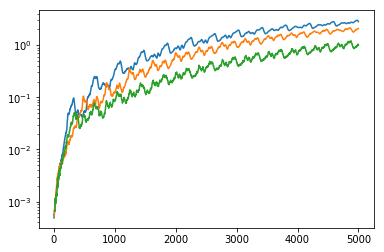

In [122]:
plt.semilogy(t_list, mse_small, label = "small")
plt.semilogy(t_list_mid, mse_mid, label = "mid")
plt.semilogy(t_list_large, mse_large, label = "large")
plt.semilogy(t_list, mse, 'k', label = "both")

plt.xlim([0,1000])

y_preds = net_regular.vectorized_multi_scale_forecast(torch.tensor(test_data[:, 0, :]).float().to('cpu'), n_steps=n_steps, models=models_regular)
mse_regular = torch.mean((y_preds - torch.tensor(test_data[:, 1:1+n_steps, :]).float())**2, axis = (0,2))
plt.plot(mse_regular, label = " multiscale regular")

plt.legend()

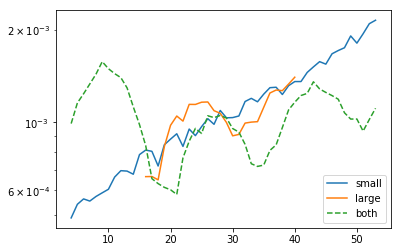

In [123]:
plt.semilogy(t_list[:50], mse_small[:50], label = "small")

plt.semilogy(t_list_large[:25], mse_large[:25], label = "large")
plt.semilogy(t_list[:50], mse[:50], '--', label = "both")
plt.legend()
# plt.xlim([0,200])

In [102]:
print(mse[:20])
print(mse_large[:10])

[0.00043857 0.00048595 0.00055374 0.00069042 0.00073694 0.00078642
 0.00097957 0.00108159 0.00136502 0.00150643 0.00168256 0.00191237
 0.00209405 0.00229929 0.00249592 0.00281474 0.00303126 0.0036193
 0.00409495 0.00461416]
[0.00048595 0.00069042 0.00078642 0.00108159 0.00150643 0.00191237
 0.00229929 0.00281474 0.0036193  0.00461416]


(320, 1250, 2)
(320, 625, 2)


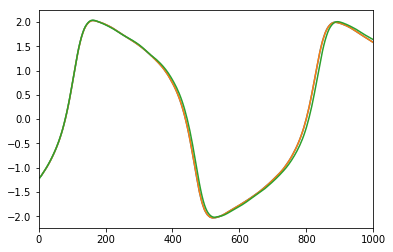

In [99]:
print(y_pred_list.shape)
print(y_pred_list_large.shape)
plt.plot(t_list[1:], y_pred_list[1,1:,0])
plt.plot(t_list_large, y_pred_list_large[1,:,0])
plt.plot(t_list, y_pred_list_small[1,:,0])
plt.xlim([0,1000])
plt.show()
# print(y_pred_list[0,::2,0].shape)
# print( y_pred_list_large[0,:,0].shape)
# plt.plot(y_pred_list[0,1::2,0]- y_pred_list_large[0,:,0])

In [89]:
print(y_pred_list[0,:10,0])
print(y_pred_list_large[0,:10,0])


[1.2760594 1.3328774 1.3878925 1.4327617 1.4744774 1.505684  1.5347683
 1.5559645 1.5757298 1.5860764]
[1.3328774  1.43276167 1.50568402 1.55596447 1.58607638 1.60540092
 1.61285377 1.61104465 1.60261405 1.58785665]


torch.Size([320, 2])


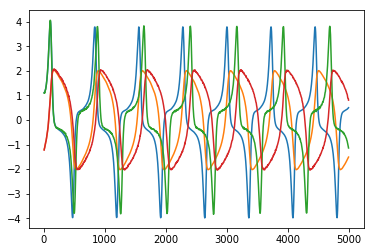

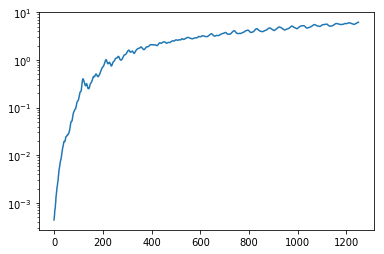

torch.Size([320, 2])


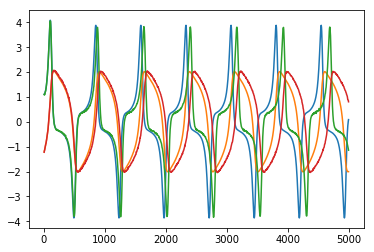

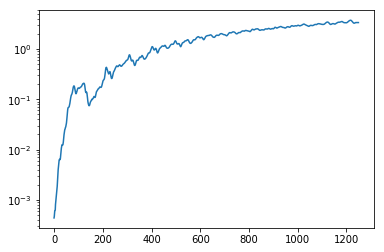

torch.Size([320, 2])


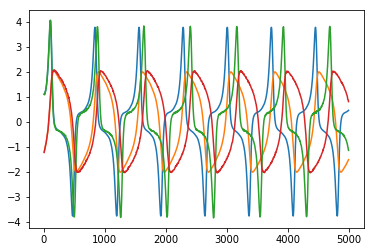

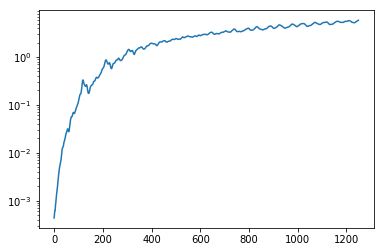

torch.Size([320, 2])


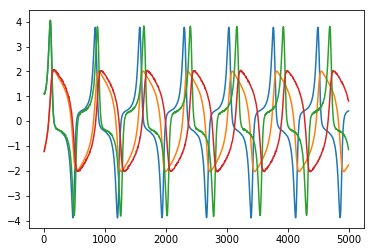

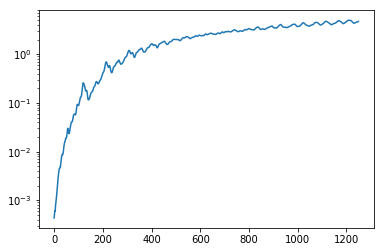

torch.Size([320, 2])


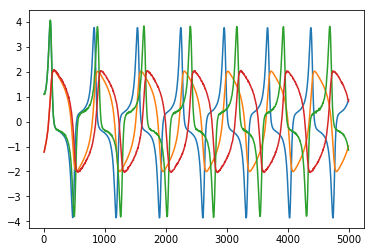

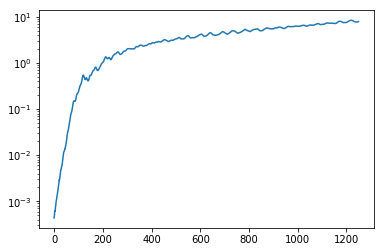

In [55]:
#predict all models
mse_list = list()
y_pred_list = list()
for model in models:
    y_preds, mse, t_list = predict_small_scale(model, step_size)
    mse_list.append(mse)

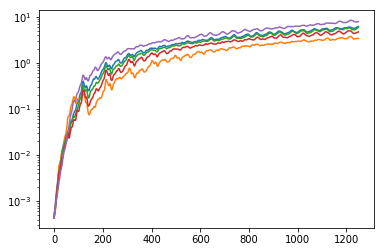

In [34]:
for mse in mse_list:
    plt.semilogy(mse)

In [35]:
#now want to plot the regular way with this one. 
import ResNet as net
test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise)))
# load models
model_dir_regular = os.path.join('../../models/', system)
print(model_dir_regular)
# models = list()
# for noise in noise_levels:
try:
    model_name = 'model_D{}_noise{}.pt'.format(step_size, noise)
    print(model_name)
    model_regular = torch.load(os.path.join(model_dir_regular, model_name), map_location='cpu')
except:
    print("not found")
#     break

# # fix model coistencies trained on gpus (optional)
model_regular.device = 'cpu'
model_regular._modules['increment']._modules['activation'] = torch.nn.ReLU()
  
n_steps = 5000
y_preds = model_regular.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
mse_regular = torch.mean((y_preds - test_data[:,1:n_steps+1,:])**2, axis = (0,2))

../../models/VanDerPol
model_D4_noise0.01.pt


/home/kjohnst/.local/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/kjohnst/.local/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/kjohnst/multiscale_HiTS_depends/src/ResNet.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.t

(0, 1000)

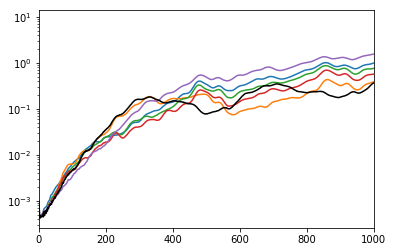

In [37]:
for mse in mse_list:
    plt.semilogy(t_list, mse)
plt.semilogy(mse_regular, 'k')
plt.xlim([0,1000])

In [49]:
print(step_size_list)
print(noise_list)
print(len(step_size_list))

[4, 4, 4, 4, 4]
[0.1, 0.1, 0.1, 0.1, 0.1]
5


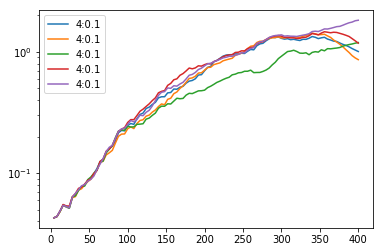

In [51]:
error = 0.2
for i in range(len(mse_list)):
#     if noise_list[i] == error:
        plt.semilogy(t_list_all[i][:100], mse_list[i][:100], label = str(step_size_list[i]) + ":"+ str(noise_list[i]))
    
# plt.title("error = " + str(error))
plt.legend()

In [58]:
# load model from regular way
models = list()
model_dir_regular = '../../models/VanDerPol'
# for noise in noise_levels:
try:
    model_name = 'model_D{}_noise{}.pt'.format(step_size, noise)
    model1 = torch.load(os.path.join(model_dir, model_name), map_location='cpu')
except:
    print("not found")
#     break

# fix model consistencies trained on gpus (optional)
model1.device = 'cpu'
# model1._modules['small']._modules['activation'] = torch.nn.ReLU()
# model1._modules['large']._modules['activation'] = torch.nn.ReLU()
  
    
#want to find mse


timesteps = 5000

y_pred_list = list()
t_list = list()
# step_size = 8
t = 0

points = timesteps // step_size

y_preds = model1.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=points)


print(points)

t_list = np.zeros(points)
y_pred_list = np.zeros((320, points, 2))

t+= step_size
y_preds = model1.forward(torch.tensor(test_data[:, 0]).float(), step_size)#, 'small')
y_pred_list[:,0] = y_preds.detach().numpy()
t_list[0] = t
print(y_preds.shape)

for j in range(points-1):
    t+= step_size
    y_preds = model1.forward(y_preds)#, 'small')
    
    y_pred_list[:,j+1] = y_preds.detach().numpy()
    t_list[j+1] = t
    
    
plt_idx = 1

plt.plot(t_list, y_pred_list[plt_idx,:, 1])
plt.plot(t_list, y_pred_list[plt_idx,:, 0])

plt.plot(t_list, test_data[plt_idx,t_list.astype(int), 1])
plt.plot(t_list, test_data[plt_idx,t_list.astype(int), 0])

# print(test_data[:,:804:4].shape)
mse4_model1 = np.mean((y_pred_list - test_data[:,t_list.astype(int)])**2, axis = (0,2))
t_list4 = t_list
# plt.xlim([0,1000])
plt.show()

plt.semilogy(mse4_model1)

mse_list.append(mse4_model1)
step_size_list.append(step_size)
noise_list.append(noise)
t_list_all.append(t_list)

TypeError: forward() missing 1 required positional argument: 'step_size'

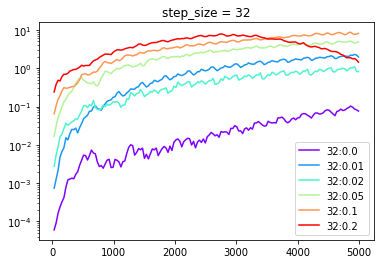

In [448]:
step_size = 32
color = iter(plt.cm.rainbow(np.linspace(0, 1, 6)))
for i in range(len(mse_list)):
    if step_size_list[i] == step_size:
        c = next(color)
        plt.semilogy(t_list_all[i], mse_list[i], label = str(step_size_list[i]) + ":"+ str(noise_list[i]), c=c)
    
plt.title("step_size = " + str(step_size))
plt.legend()

In [219]:
step_size_list

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]

In [56]:
#want to find mse


timesteps = 5000

y_pred_list = list()
t_list = list()
# step_size = 8
t = 0

points = timesteps // step_size

y_preds = model1.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=points)

# print(points)

# t_list = np.zeros(points)
# y_pred_list = np.zeros((320, points, 2))

# t+= step_size
# y_preds = model2.forward(torch.tensor(test_data[:, 0]).float(), 'small')
# y_pred_list[:,0] = y_preds.detach().numpy()
# t_list[0] = t
# print(y_preds.shape)

# for j in range(points-1):
#     t+= step_size
#     y_preds = model2.forward(y_preds, 'small')
    
#     y_pred_list[:,j+1] = y_preds.detach().numpy()
#     t_list[j+1] = t
    
    
plt_idx = 1

plt.plot(t_list, y_preds[plt_idx,:, 1])
plt.plot(t_list, y_preds[plt_idx,:, 0])

plt.plot(t_list, y_preds[plt_idx,t_list.astype(int), 1])
plt.plot(t_list, y_preds[plt_idx,t_list.astype(int), 0])

# print(test_data[:,:804:4].shape)
mse4_model2 = np.mean((y_pred_list - test_data[:,t_list.astype(int)])**2, axis = (0,2))
t_list4 = t_list
# plt.xlim([0,1000])
plt.show()

plt.semilogy(mse4_model2)

TypeError: forward() missing 1 required positional argument: 'step_size'

1250
torch.Size([320, 2])


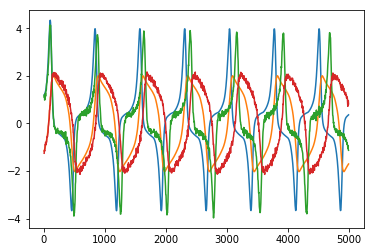

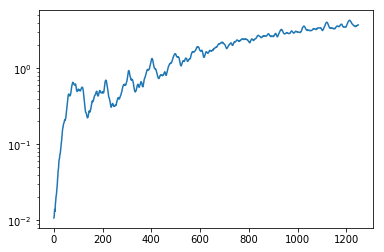

In [133]:
#want to find mse


timesteps = 5000

y_pred_list = list()
t_list = list()
# step_size = 8
t = 0

points = timesteps // step_size

print(points)

t_list = np.zeros(points)
y_pred_list = np.zeros((320, points, 2))

t+= step_size
y_preds = model_regular.forward(torch.tensor(test_data[:, 0]).float())
y_pred_list[:,0] = y_preds.detach().numpy()
t_list[0] = t
print(y_preds.shape)

for j in range(points-1):
    t+= step_size
    y_preds = model_regular.forward(y_preds)
    
    y_pred_list[:,j+1] = y_preds.detach().numpy()
    t_list[j+1] = t
    
    
plt_idx = 1

plt.plot(t_list, y_pred_list[plt_idx,:, 1])
plt.plot(t_list, y_pred_list[plt_idx,:, 0])

plt.plot(t_list, test_data[plt_idx,t_list.astype(int), 1])
plt.plot(t_list, test_data[plt_idx,t_list.astype(int), 0])

# print(test_data[:,:804:4].shape)
mse4__regular = np.mean((y_pred_list - test_data[:,t_list.astype(int)])**2, axis = (0,2))
t_list4 = t_list
# plt.xlim([0,1000])
plt.show()

plt.semilogy(mse4__regular)

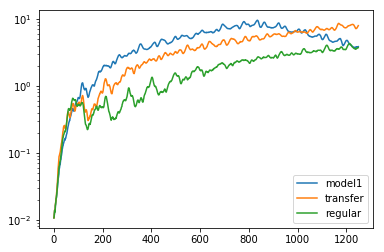

In [134]:
plt.semilogy(mse4_model1, label = "model1")
plt.plot(mse4_model2, label = "transfer")
plt.plot(mse4__regular, label = "regular")
plt.legend()

In [39]:
#want to find mse

y_pred_list = list()
t_list = list()
step_size = 16
t = 0

points = timesteps // step_size

t_list = np.zeros(points)
y_pred_list = np.zeros((320, points, 2))

t+= step_size
y_preds = models[0].forward(torch.tensor(test_data[:, 0]).float(), 'large')
y_pred_list[:,0] = y_preds.detach().numpy()
t_list[0] = t
print(y_preds.shape)

for j in range(points-1):
    t+= step_size
    y_preds = models[0].forward(y_preds, 'large')
    
    y_pred_list[:,j+1] = y_preds.detach().numpy()
    t_list[j+1] = t
    

print(t_list.shape)
print(y_pred_list.shape)

plt.plot(t_list, y_pred_list[0,:, 1])
plt.plot(t_list, y_pred_list[0,:, 0])

plt.plot(t_list, test_data[0,t_list.astype(int), 1])
plt.plot(t_list, test_data[0,t_list.astype(int), 0])
mse8 = np.mean((y_pred_list - test_data[:,t_list.astype(int)])**2, axis = (0,2))
t_list8 = t_list
plt.show()

plt.semilogy(mse8)

IndexError: list index out of range

(0, 1000)

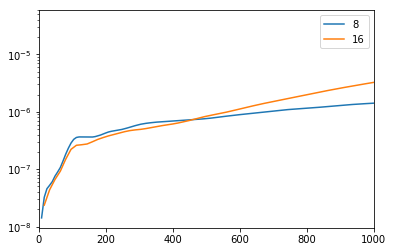

In [87]:
plt.semilogy(t_list4, mse4, label = "8")
plt.semilogy(t_list8, mse8, label = "16")
plt.legend()

plt.xlim([0, 1000])

# plt.ylim([1e-2, 10])

model_D8_noise0.0.pt


/home/kjohnst/.local/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/kjohnst/.local/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/kjohnst/multiscale_HiTS_depends/src/ResNet.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.t

Text(0.5,1,'Noise explore of Hyperbolic: step_size = 8')

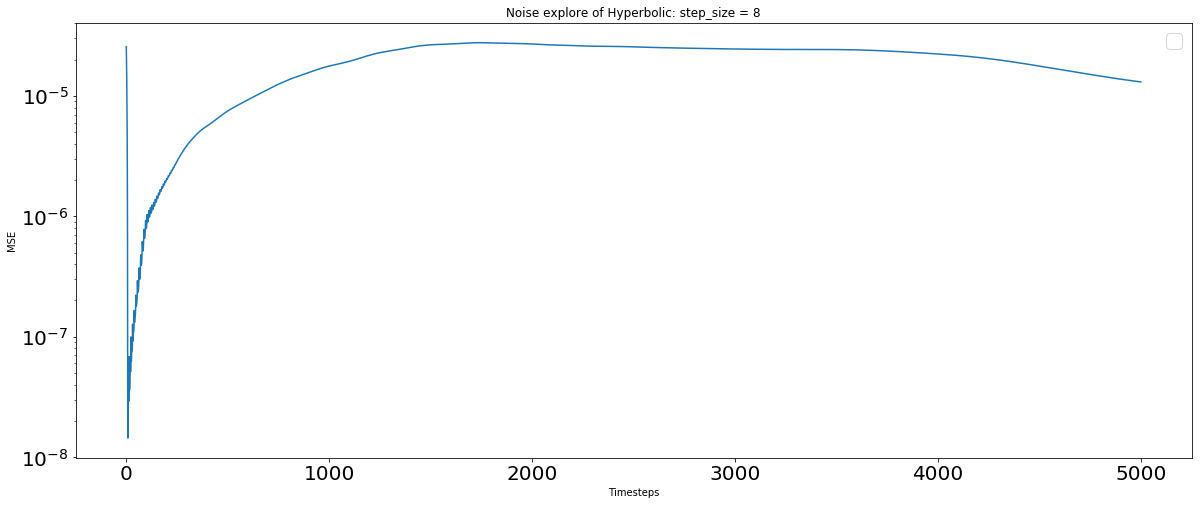

In [72]:
#want to plot with regular way too

step_size = 8
model_dir_regular = os.path.join('../../models/', system)
# load models
models = list()
# for noise in noise_levels:
try:
    model_name = 'model_D{}_noise{}.pt'.format(step_size, noise)
    print(model_name)
    models.append(torch.load(os.path.join(model_dir_regular, model_name), map_location='cpu'))
except:
    print("not found")
#     break

# fix model consistencies trained on gpus (optional)
for model in models:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

#graph for d1

mse_list_big = list()
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(models))))
# for k in range(len(preds_mse)):
#     err = preds_mse[k]
#     mean = err.mean(0).detach().numpy()
    
#     plt.semilogy(mean, linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))


n_steps = 5000
for i in range(len(models)):
    test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise)))
    rgb = next(colors)
    y_preds = models[i].uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
#     plt.plot(y_preds[0,:,0].cpu().detach().numpy())
#     plt.plot(y_preds[0,:,1].cpu().detach().numpy())

#     plt.plot(test_data[0,1:n_steps,0])#.cpu().detach().numpy())
#     plt.plot(test_data[0,1:n_steps,1])#.cpu().detach().numpy())
# # plt.show()

# print((y_preds_2 - test_data[:,1:,:]).shape)

# print(((y_preds_2 - test_data[:,1:,:])**2).shape)

    mse_regular = torch.mean((y_preds - test_data[:,1:n_steps+1,:])**2, axis = (0,2))
    mse_list_big.append(mse_regular)

    plt.semilogy(mse_regular)#, label = str(noise_levels[i]*100) + "%", color=rgb)

plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# plt.ylim([1e-2, 10])
plt.ylabel("MSE")
plt.xlabel("Timesteps")
plt.title("Noise explore of " + system + ": step_size = "+ str(step_size))

model_D16_noise0.0.pt


/home/kjohnst/.local/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/kjohnst/.local/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/kjohnst/multiscale_HiTS_depends/src/ResNet.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.t

Text(0.5,1,'Noise explore of Hyperbolic: step_size = 16')

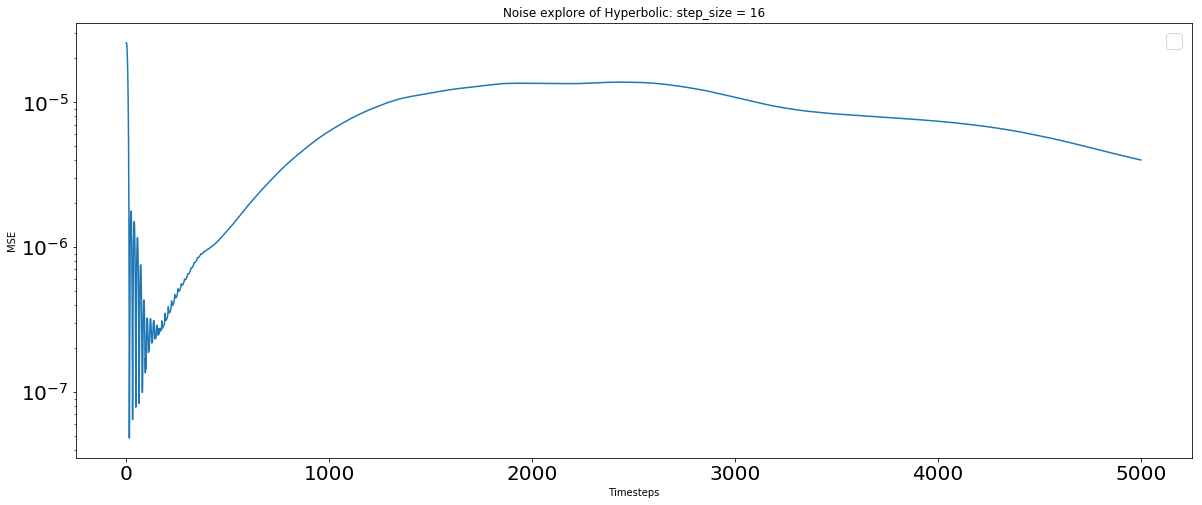

In [73]:
#want to plot with regular way too

step_size = 16
model_dir_regular = os.path.join('../../models/', system)
# load models
models = list()
# for noise in noise_levels:
try:
    model_name = 'model_D{}_noise{}.pt'.format(step_size, noise)
    print(model_name)
    models.append(torch.load(os.path.join(model_dir_regular, model_name), map_location='cpu'))
except:
    print("not found")
#     break

# fix model consistencies trained on gpus (optional)
for model in models:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

#graph for d1

mse_list_big = list()
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(models))))
# for k in range(len(preds_mse)):
#     err = preds_mse[k]
#     mean = err.mean(0).detach().numpy()
    
#     plt.semilogy(mean, linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))


n_steps = 5000
for i in range(len(models)):
    test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise)))
    rgb = next(colors)
    y_preds = models[i].uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
#     plt.plot(y_preds[0,:,0].cpu().detach().numpy())
#     plt.plot(y_preds[0,:,1].cpu().detach().numpy())

#     plt.plot(test_data[0,1:n_steps,0])#.cpu().detach().numpy())
#     plt.plot(test_data[0,1:n_steps,1])#.cpu().detach().numpy())
# # plt.show()

# print((y_preds_2 - test_data[:,1:,:]).shape)

# print(((y_preds_2 - test_data[:,1:,:])**2).shape)

    mse_regular8 = torch.mean((y_preds - test_data[:,1:n_steps+1,:])**2, axis = (0,2))
    mse_list_big.append(mse_regular8)

    plt.semilogy(mse_regular8)#, label = str(noise_levels[i]*100) + "%", color=rgb)

plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# plt.ylim([1e-2, 10])
plt.ylabel("MSE")
plt.xlabel("Timesteps")
plt.title("Noise explore of " + system + ": step_size = "+ str(step_size))

312
torch.Size([313])


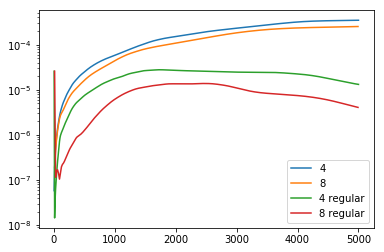

In [75]:
plt.semilogy(t_list4, mse4, label = "4")
plt.semilogy(t_list8, mse8, label = "8")

plt.semilogy(t_list4, mse_regular[::8], label = "4 regular")
print(len(t_list8))
print(mse_regular8[::16].shape)
plt.semilogy(t_list8, mse_regular8[:-10:16], label = "8 regular")
plt.legend()

# plt.xlim([0, 200])

# plt.ylim([1e-2, 1])

In [14]:
mse4.shape

(1250,)

In [24]:

import torch
import numpy as np
import scipy.interpolate
from utils_multiscale import DataSet
import time
def vectorized_multi_scale_forecast(self, x_init, n_steps, step_sizes = [8,4]):
        """
        :param x_init: initial state torch array of shape n_test x n_dim
        :param n_steps: number of steps forward in terms of dt
        :param models: a list of models
        :return: a torch array of size n_test x n_steps x n_dim,
                 a list of indices that are not achieved by interpolations
        """
        # sort models by their step sizes (decreasing order)
#         step_sizes = [model.step_size for model in models]
#         step_sizes = 
#         models = [model for _, model in sorted(zip(step_sizes, models), reverse=True)]

        

        # we assume models are sorted by their step sizes (decreasing order)
        n_test, n_dim = x_init.shape
        device = 'cpu'#'cuda' if torch.cuda.is_available() else 'cpu'
        indices = list()
        extended_n_steps = n_steps + step_sizes[0]
        preds = torch.zeros(n_test, extended_n_steps + 1, n_dim).float().to(device)

        # vectorized simulation
        indices.append(0)
        preds[:, 0, :] = x_init
        total_step_sizes = n_steps
#         for model in models:
        type_models = ['large', 'small']
        for i in [0,1]:
            step_size = step_sizes[i]
            type_model = type_models[i]
            n_forward = int(total_step_sizes/step_size)
            y_prev = preds[:, indices, :].reshape(-1, n_dim)
            indices_lists = [indices]
            for t in range(n_forward):
                y_next = self.forward(y_prev, type_model)
                shifted_indices = [x + (t + 1) * step_size for x in indices]
                indices_lists.append(shifted_indices)
                preds[:, shifted_indices, :] = y_next.reshape(n_test, -1, n_dim)
                y_prev = y_next
            indices = [val for tup in zip(*indices_lists) for val in tup]
            total_step_sizes = step_size - 1

        # simulate the tails
        last_idx = indices[-1]
        y_prev = preds[:, last_idx, :]
        while last_idx < n_steps:
            last_idx += step_size[-1]
            type_model = type_models[-1]
            y_next = mself.forward(y_prev, type_model)
            preds[:, last_idx, :] = y_next
            indices.append(last_idx)
            y_prev = y_next

        print(preds.shape)
        plt.plot(preds[plt_idx,:,0].detach().numpy())
        plt.plot(preds[plt_idx,:,1].detach().numpy())
        
        
        plt.plot(t_list, y_pred_list[plt_idx,:, 1])
        plt.plot(t_list, y_pred_list[plt_idx,:, 0])

        plt.plot(t_list, test_data[plt_idx,t_list.astype(int), 1])
        plt.plot(t_list, test_data[plt_idx,t_list.astype(int), 0])
        plt.xlim([0,1000])

        # interpolations
        sample_steps = range(1, n_steps+1)
        valid_preds = preds[:, indices, :].detach().numpy()
        cs = scipy.interpolate.interp1d(indices, valid_preds, kind='lin/ear', axis=1)
        y_preds = torch.tensor(cs(sample_steps)).float()

        return y_preds
    
step_size = 4
# load models
models = list()
# for noise in noise_levels:
try:
    model_name = 'model_D{}_noise{}.pt'.format(step_size, noise)
    print(model_name)
    models.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
except:
    print("not found")
#     break

# fix model consistencies trained on gpus (optional)
for model in models:
    model.device = 'cpu'
    model._modules['small']._modules['activation'] = torch.nn.ReLU()
    model._modules['large']._modules['activation'] = torch.nn.ReLU()
  

model_D4_noise0.05.pt


/home/kjohnst/.local/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'Resnet_multiscale.ResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/kjohnst/.local/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/kjohnst/.local/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's sourc

torch.Size([320, 1009, 2])


NotImplementedError: lin/ear is unsupported: Use fitpack routines for other types.

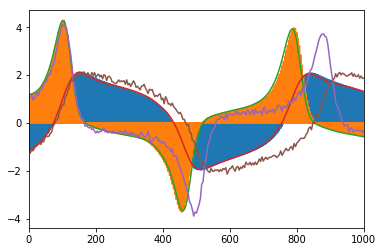

In [25]:
y_preds = vectorized_multi_scale_forecast(models[0], torch.tensor(test_data[:, 0]).float(), 1000)